In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('features_all_letters.csv' , encoding='latin-1')

In [3]:
df.head

<bound method NDFrame.head of       instance_id        x1        y1            z1        x2        y2  \
0               0  0.473853  0.663629 -1.179010e-06  0.630562  0.659320   
1               1  0.449209  0.770086 -9.853312e-07  0.600657  0.688664   
2               2  0.528904  0.826094 -9.720477e-07  0.669881  0.710788   
3               3  0.580398  0.728590 -5.448370e-07  0.664301  0.622819   
4               4  0.774271  0.384729  7.318209e-08  0.741370  0.418124   
...           ...       ...       ...           ...       ...       ...   
3656         3656  0.858485  0.863983 -1.761462e-06  0.885718  0.695556   
3657         3657  0.778131  0.887421 -1.008092e-06  0.790115  0.750785   
3658         3658  0.708135  0.792624 -1.103526e-06  0.792742  0.638804   
3659         3659  0.721643  0.783280 -9.761108e-07  0.809707  0.639879   
3660         3660  0.836473  0.793185 -1.463425e-06  0.875384  0.639220   

            z2        x3        y3        z3  ...       x19       y19

In [4]:
X = df.drop(columns=["instance_id", "label"]).values
y = df["label"].values

In [5]:
from sklearn.preprocessing import LabelEncoder

#Convert text data into numbers as most machine learning algorithms work on numeric labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=42, test_size=0.2)

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
param_grid = {
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring="accuracy")

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [10]:
best_dt = grid_search.best_estimator_
best_dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(min_samples_split=5, random_state=42)

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred_dt = best_dt.predict(X_test_scaled)

dt_test_acc = accuracy_score(y_test, y_pred_dt)
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Decision Tree CV accuracy:", grid_search.best_score_)
print("Decision Tree Test Accuracy:", dt_test_acc)

print(confusion_matrix(y_test, y_pred_dt))

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5}
Best Decision Tree CV accuracy: 0.9023289869023656
Decision Tree Test Accuracy: 0.8867667121418826
[[76  2  0  1  4  0  0  0  4  2]
 [ 0 78  3  0  0  1  0  0  0  0]
 [ 0  6 53  0  1  2  0  0  1  1]
 [ 0  0  2 65  1  0  2  1  0  0]
 [ 7  0  0  0 70  0  0  1  1  2]
 [ 0  3  1  0  2 77  0  0  2  0]
 [ 0  0  0  1  0  1 61  0  0  0]
 [ 0  0  1  3  0  0  1 66  0  0]
 [ 1  0  0  0  0  0  0  0 53  6]
 [ 1  0  0  0  2  0  3  1  9 51]]


In [12]:
import math
from collections import Counter


#Euclidian distance to measure the similarity between target and training data points
def euclidean_distance(p1, p2):
    total = 0
    #Iterates index by index through the vectors
    for i in range(len(p1)):
        #Subtract corresponding feature values
        difference = p1[i] - p2[i]
        #Sums all squared differences
        total += difference * difference
        #Return square root
    return math.sqrt(total)

#Predict class label for each test instance using kNN
def knn_predict(X_train, y_train, X_test, k):
    predictions = []

    #Loop over test points
    for test_point in X_test:
        distances = []

        #Compute distance to every training sample
        for i in range(len(X_train)):
            train_point = X_train[i]
            label = y_train[i]

            dist = euclidean_distance(test_point, train_point)
            distances.append((dist, label))

        #Sort by distance so nearest neighbours appear first
        distances.sort(key=lambda x: x[0])
        #Take the k nearest neighbours
        k_nearest = distances[:k]

        neighbour_labels = []
        for item in k_nearest:
            neighbour_labels.append(item[1])

        #Choose the most frequent label
        most_common_label = Counter(neighbour_labels).most_common(1)[0][0]
        predictions.append(most_common_label)

    return predictions

In [13]:
#Perform 5-fold cross-validation to estimate model performance
def knn_cross_val(X, y, k_neighbours, folds=5):
    #Split data into folds
    fold_size = math.floor(len(X)/folds)
    accuracies = []

    #Loop through folds
    for i in range(folds):
        #Each fold becomes the validation set once
        start = i * fold_size
        end = start + fold_size

        X_val = X[start:end]
        y_val = y[start:end]

        X_train = X[:start] + X[end:]
        y_train = y[:start] + y[end:]

        #Predict validation labels
        predict_val_label = knn_predict(X_train, y_train, X_val, k_neighbours)

        #Compute accuracy
        #Accuracy = correct predictions ÷ total predictions
        correct = 0
        for j in range(len(y_val)):
            if predict_val_label[j] == y_val[j]:
                correct += 1

        acc = correct / len(y_val)
        accuracies.append(acc)

    #Returns cross-validation accuracy for a given k.
    return sum(accuracies) / len(accuracies)


In [14]:
#Convert NumPy arrays to Python lists using tolist function
X_train_list = X_train_scaled.tolist()
y_train_list = y_train.tolist()

#Define k values to test
#Use odd numbers to prevent ties in majority voting
k_values = [1, 3, 5, 7, 9]
#Dictionary to store cross-validation results
knn_results = {}

#Loop to run 5-fold cross-validation for each k
for k in k_values:
    stored_accuracy = knn_cross_val(X_train_list, y_train_list, k)
    knn_results[k] = stored_accuracy
    #Print CV accuracy
    print(f"k={k}, CV accuracy={stored_accuracy:.3f}")

#Looks at all k values and select the one with highest CV accuracy
best_k = max(knn_results, key=knn_results.get)
print("Best KNN CV accuracy:", knn_results[best_k])


k=1, CV accuracy=0.929
k=3, CV accuracy=0.923
k=5, CV accuracy=0.925
k=7, CV accuracy=0.925
k=9, CV accuracy=0.926
Best KNN CV accuracy: 0.9292307692307693


In [15]:
#Predicting on the test set using best k
y_pred_knn = knn_predict(
    ##Convert NumPy arrays to Python lists using tolist function
    X_train_scaled.tolist(),
    y_train.tolist(),
    X_test_scaled.tolist(),
    best_k
)

#Count how many predictions are correct
correct_prediction = 0

for i in range(len(y_test)):
    #Compare prediction with true label, prediction correct if they match
    if y_pred_knn[i] == y_test[i]:
        #Count correct predictions
        correct_prediction += 1

#Compute accuracy
knn_test_acc = correct_prediction / len(y_test)

# final kNN performance
print("kNN Test Accuracy:", knn_test_acc)


kNN Test Accuracy: 0.9454297407912687


In [16]:
from sklearn.svm import SVC

svm = SVC()


#Define hyperparameter search space
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"]
}

#Set up GridSearch with 5-fold cross-validation
grid_svm = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy"
)

#Run the hyperparameter search
grid_svm.fit(X_train_scaled, y_train)

#Get the best SVM model with the highest mean CV accuracy
best_svm = grid_svm.best_estimator_

#Make predictions on the test set
#Evaluates models ability to perform on unseen data
y_pred_svm = best_svm.predict(X_test_scaled)

print("Best SVM hyperparameters:", grid_svm.best_params_)

print("Best SVM CV accuracy:", grid_svm.best_score_)


Best SVM hyperparameters: {'C': 10, 'kernel': 'rbf'}
Best SVM CV accuracy: 0.9624351681689566


In [17]:
from sklearn.metrics import accuracy_score

#Calculate percentage of correct predictions on test set
svm_test_acc = accuracy_score(y_test, y_pred_svm)

print("SVM Test Accuracy:", svm_test_acc)

SVM Test Accuracy: 0.9672578444747613


In [ ]:
results_summary = pd.DataFrame({
    "Classifier": ["Decision Tree", "kNN", "SVM"],
    "Best CV Accuracy": [grid_search.best_score_, knn_results[best_k],grid_svm.best_score_],
    "Test Accuracy": [dt_test_acc, knn_test_acc, svm_test_acc]})

print(results_summary)


      Classifier  Best CV Accuracy  Test Accuracy
0  Decision Tree          0.902329       0.886767
1            kNN          0.929231       0.945430
2            SVM          0.962435       0.967258


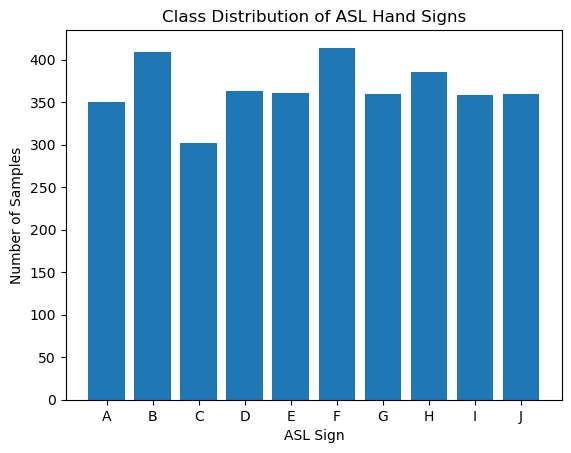

In [22]:
import matplotlib.pyplot as plt

class_counts = Counter(y)

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("ASL Sign")
plt.ylabel("Number of Samples")
plt.title("Class Distribution of ASL Hand Signs")
plt.show()
